### **0. Генерация исторических данных**

In [2]:
import pandas as pd
import numpy as np

# Реальные средние температуры (примерные данные) для городов по сезонам
seasonal_temperatures = {
    "New York": {"winter": 0, "spring": 10, "summer": 25, "autumn": 15},
    "London": {"winter": 5, "spring": 11, "summer": 18, "autumn": 12},
    "Paris": {"winter": 4, "spring": 12, "summer": 20, "autumn": 13},
    "Tokyo": {"winter": 6, "spring": 15, "summer": 27, "autumn": 18},
    "Moscow": {"winter": -10, "spring": 5, "summer": 18, "autumn": 8},
    "Sydney": {"winter": 12, "spring": 18, "summer": 25, "autumn": 20},
    "Berlin": {"winter": 0, "spring": 10, "summer": 20, "autumn": 11},
    "Beijing": {"winter": -2, "spring": 13, "summer": 27, "autumn": 16},
    "Rio de Janeiro": {"winter": 20, "spring": 25, "summer": 30, "autumn": 25},
    "Dubai": {"winter": 20, "spring": 30, "summer": 40, "autumn": 30},
    "Los Angeles": {"winter": 15, "spring": 18, "summer": 25, "autumn": 20},
    "Singapore": {"winter": 27, "spring": 28, "summer": 28, "autumn": 27},
    "Mumbai": {"winter": 25, "spring": 30, "summer": 35, "autumn": 30},
    "Cairo": {"winter": 15, "spring": 25, "summer": 35, "autumn": 25},
    "Mexico City": {"winter": 12, "spring": 18, "summer": 20, "autumn": 15},
}

# Сопоставление месяцев с сезонами
month_to_season = {12: "winter", 1: "winter", 2: "winter",
                   3: "spring", 4: "spring", 5: "spring",
                   6: "summer", 7: "summer", 8: "summer",
                   9: "autumn", 10: "autumn", 11: "autumn"}

# Генерация данных о температуре
def generate_realistic_temperature_data(cities, num_years=10):
    dates = pd.date_range(start="2010-01-01", periods=365 * num_years, freq="D")
    data = []

    for city in cities:
        for date in dates:
            season = month_to_season[date.month]
            mean_temp = seasonal_temperatures[city][season]
            # Добавляем случайное отклонение
            temperature = np.random.normal(loc=mean_temp, scale=5)
            data.append({"city": city, "timestamp": date, "temperature": temperature})

    df = pd.DataFrame(data)
    df['season'] = df['timestamp'].dt.month.map(lambda x: month_to_season[x])
    return df

# Генерация данных
data = generate_realistic_temperature_data(list(seasonal_temperatures.keys()))
data.to_csv('temperature_data.csv', index=False)


### **1. Анализ исторических данных**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('temperature_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [46]:
# Вычисление скользящего среднего за 30 дней
df_30d_roll_temp = (
    df.groupby(['city'])
      .rolling(window='30D', on='timestamp', min_periods=1)['temperature']
      .mean()
      .reset_index()                        
)
df_30d_roll_temp = df_30d_roll_temp.rename(columns={'temperature': 'temperature_30d_rol_mean'})

df = df.merge(df_30d_roll_temp, on=['city', 'timestamp'], how='left')

In [47]:
# Вычисление средних и стандартных отклонений температур по городам и сезонам
df_mean_std = (
    df.groupby(['city', 'season'], as_index=False)
    .agg(temperature_mean=('temperature', 'mean'),
         temperature_std=('temperature', 'std'))
)

df = df.merge(df_mean_std, on=['city', 'season'], how='left')

In [48]:
# Определение аномалий на основе отклонений от скользящего среднего
def mark_outliers(data):
    df_copy = data.copy()
    df_copy['is_outlier'] = (
        (df_copy['temperature'] < df_copy['temperature_30d_rol_mean'] - 2 * df_copy['temperature_std']) |
        (df_copy['temperature'] > df_copy['temperature_30d_rol_mean'] + 2 * df_copy['temperature_std'])
    )
    return df_copy

df = mark_outliers(df)

In [49]:
# Вычисление скользящего среднего за год для построения тренда
df_365d_roll_temp = (
    df.groupby(['city'])
      .rolling(window='365D', on='timestamp', min_periods=1)['temperature']
      .mean()
      .reset_index()                        
)
df_365d_roll_temp = df_365d_roll_temp.rename(columns={'temperature': 'temperature_365d_rol_mean'})
df = df.merge(df_365d_roll_temp, on=['city', 'timestamp'], how='left')

-0.032 °C в год


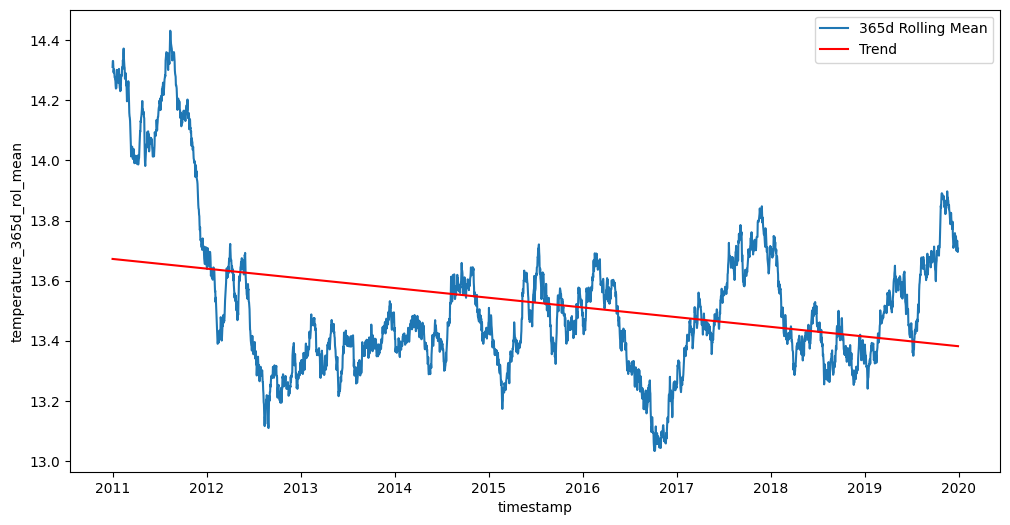

In [50]:
# Функция для вычисления и отображения тренда температуры
def calculate_trend(data, city_name="New York"):
    df_trend = data[(data['timestamp'] >= "2011-01-01") & (data['city'] == city_name)].copy()
    df_trend['num_col'] = range(len(df_trend))

    x = df_trend['num_col'].values
    y = df_trend['temperature_365d_rol_mean'].values
    coef = np.polyfit(x, y, 1)
    trend = np.poly1d(coef)

    df_trend['trend'] = trend(x)
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_trend, x='timestamp', y='temperature_365d_rol_mean', label='365d Rolling Mean')
    sns.lineplot(data=df_trend, x='timestamp', y='trend', color='red', label='Trend')
    print(f"{'+' if coef[0] * 365 > 0 else ''}{coef[0] * 365:.3f} °C в год")

calculate_trend(df, city_name="Beijing")

In [ ]:
df.query('city == "Moscow"')[['season', 'temperature_mean', 'temperature_std']].drop_duplicates()

,season,temperature_mean,temperature_std
14600,winter,-10.011337,4.851538
14659,spring,4.894596,4.986285
14751,summer,18.152545,5.088028
14843,autumn,8.107879,5.025847


### **2. Мониторинг текущей температуры**

In [35]:
import requests
import datetime
import asyncio
import httpx
import time
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio
nest_asyncio.apply()

In [36]:
# Параметры для запроса к OpenWeatherMap API
API_KEY = ""
CITY = "Moscow"
TODAY = datetime.date.today()
URL = "https://api.openweathermap.org/data/2.5/weather"
PARAMS = {
    "q": CITY,
    "appid": API_KEY,
    "units": "metric",
    "lang": "ru"
}

In [37]:
# Тестовый запрос к API
response = requests.get(URL, params=PARAMS)
data = response.json()

if response.status_code == 200:
    temp = data["main"]["temp"]
    feels_like = data["main"]["feels_like"]
    description = data["weather"][0]["description"]
    print(f"Город: {CITY}")
    print(f"Температура: {temp}°C")
    print(f"Ощущается как: {feels_like}°C")
    print(f"Погода: {description}")
else:
    print("Ошибка:", data)

Город: Moscow
Температура: -1.13°C
Ощущается как: -4.73°C
Погода: пасмурно


In [38]:
# Синхронная функция для получения температуры из OpenWeatherMap API
def get_temperature(city, print_output=True):
    url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": city,
        "appid": API_KEY,
        "units": "metric",
        "lang": "ru"
    }

    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code == 200:
        temp = data["main"]["temp"]
        feels_like = data["main"]["feels_like"]
        description = data["weather"][0]["description"]
        if print_output:
            print(f"{city}: {temp}°C")
        return temp, feels_like, description
    else:
        print("Ошибка:", data)

temp, feels_like, description = get_temperature(city=CITY, print_output=False)
print(f"Город: {CITY}")
print(f"Температура: {temp}°C")
print(f"Ощущается как: {feels_like}°C")
print(f"Погода: {description}")

Город: Moscow
Температура: -1.13°C
Ощущается как: -4.73°C
Погода: пасмурно


In [39]:
# Определение, является ли текущая температура аномальной
def get_season(date):
    '''Определение сезона по дате'''
    month = date.month
    if month in (12, 1, 2):
        return "winter"
    elif month in (3, 4, 5):
        return "spring"
    elif month in (6, 7, 8):
        return "summer"
    else:
        return "autumn"

def check_outlier(data, city, temperature, date):
    '''Проверка на аномальность температуры'''
    season = get_season(date)
    temp_mean, temp_std = (
        data[(data['city'] == city) & (data['season'] == season)]
        [['temperature_mean', 'temperature_std']].values[0]
    )
    if (temperature < temp_mean - 2 * temp_std) or (temperature > temp_mean + 2 * temp_std):
        return True
    return False

# Пример запуска
check_outlier(df, "Moscow", temp, TODAY)

False

In [40]:
# Проверка на аномальность текущих значений
li_res = []
cities = df.city.unique()
for city in cities:
    temp, _, _ = get_temperature(city=city, print_output=False)
    res = check_outlier(df, city, temp, TODAY)
    li_res.append((city, temp, res))
df_res = pd.DataFrame(li_res, columns=['city', 'temperature', 'is_outlier'])
df_res 

,city,temperature,is_outlier
0,New York,-3.74,False
1,London,7.53,False
2,Paris,2.40,False
3,Tokyo,4.52,False
4,Moscow,-1.13,False
5,Sydney,17.93,False
6,Berlin,0.82,False
7,Beijing,-6.06,False
8,Rio de Janeiro,32.94,True
9,Dubai,23.96,False


> В 15:26 27.12.2025 аномальное значение зафиксированно только в Рио-де-Жанейро

In [41]:
# Вывод текущих температур по городам синхронно
cities = df.city.unique()
for city in cities:
    get_temperature(city=city)

New York: -3.74°C
London: 7.53°C
Paris: 2.4°C
Tokyo: 4.52°C
Moscow: -1.13°C
Sydney: 17.93°C
Berlin: 0.82°C
Beijing: -6.06°C
Rio de Janeiro: 32.94°C
Dubai: 23.96°C
Los Angeles: 8.88°C
Singapore: 27.04°C
Mumbai: 26.99°C
Cairo: 20.42°C
Mexico City: 10.63°C


In [42]:
# Вывод текущих температур по городам параллельно с помощью потоков
def fetch_temp_threaded(cities, n_threads=len(cities) if len(cities) < 20 else 4):
    start_time = time.time()

    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        results = list(executor.map(get_temperature, cities))

    elapsed_time = time.time() - start_time
    
    return results, elapsed_time

res = fetch_temp_threaded(cities)

Mexico City: 10.63°C
Rio de Janeiro: 32.94°C
Los Angeles: 8.88°C
Dubai: 23.96°C
New York: -3.74°C
Cairo: 20.42°C
London: 7.53°C
Paris: 2.4°C
Moscow: -1.13°C
Mumbai: 26.99°C
Berlin: 0.82°C
Tokyo: 4.52°C
Sydney: 17.93°C
Singapore: 27.04°C
Beijing: -6.06°C


In [43]:
# Вывод текущих температур по городам асинхронно
async def get_temperature_async(client, city, print_output=True):
    url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": city,
        "appid": API_KEY,
        "units": "metric",
        "lang": "ru"
    }

    response = await client.get(url, params=params)
    data = response.json()

    if response.status_code == 200:
        temp = data["main"]["temp"]
        feels_like = data["main"]["feels_like"]
        description = data["weather"][0]["description"]
        if print_output:
            print(f"{city}: {temp}°C")
        return temp, feels_like, description
    else:
        print("Ошибка:", data)

async def fetch_temp_async(cities):
    start_time = time.time()

    async with httpx.AsyncClient() as client:
        tasks = [get_temperature_async(client, city) for city in cities]
        results = await asyncio.gather(*tasks)

    elapsed_time = time.time() - start_time
    return results, elapsed_time

res = asyncio.run(fetch_temp_async(cities))

Tokyo: 4.52°C
New York: -3.74°C
Los Angeles: 8.88°C
Cairo: 20.42°C
Rio de Janeiro: 32.94°C
Singapore: 27.04°C
Dubai: 23.96°C
Berlin: 0.82°C
Mumbai: 26.99°C
Beijing: -6.06°C
London: 7.53°C
Sydney: 17.93°C
Mexico City: 10.63°C
Moscow: -1.13°C
Paris: 2.4°C


- Последовательный метод с использованием цикла - 8.0s
- Последовательный метод с использование потоков (где число потоков - число городов в примере) - 1.6s
- Ассинхронный метод с использованием сесиии - 0.6s

> Очевидно, асинхронный метод получения текущей температуры лучше подходит для текущей задачи, чем последовательные.

### **3. Создание приложения на Streamlit**

In [ ]:
import streamlit as st